# to run code please attach the Case Associate Values 20220118.csv file and upload then run the notebook cells in order. Answers to Question 1a) to 1f) is answered at the end of the notebook

In [1]:
import numpy as np
import pandas as pd

In [264]:
df = pd.read_csv('Case Associate Values 20220118.csv'),header = 2)
#save the csv file in the same location as the notebook 

In [265]:
df = df.rename(columns = {'Unnamed: 0':'Date'})

In [266]:
df.set_index('Date',inplace = True)

In [267]:
df2 = df
df.head()


,SPX LEVEL,CDX IG 5Y SPREAD,CDX HY 5Y SPREAD,VIX SPOT,VIX FIRST MONTH FUTURE,VIX SECOND MONTH FUTURE,VIX THIRD MONTH FUTURE,CDX IG 5Y ON THE RUN TOTAL RETURN SERIES,VIX FUTURES INDEX SERIES TOTAL RETURN*,SPX TOTAL RETURN
Date,,,,,,,,,,
01/05/2007,1409.71,33.854,248.506,12.14,12.38,13.48,13.83,105.01195,48746.66,2173.29
01/12/2007,1430.73,33.881,231.286,10.15,10.66,12.08,13.18,105.04101,43482.37,2206.68
01/19/2007,1430.50,32.416,216.591,10.40,11.69,12.78,13.32,105.12158,42208.82,2206.60
01/26/2007,1422.18,31.796,214.757,11.13,11.88,12.78,13.47,105.15026,42690.01,2193.89
02/02/2007,1448.39,31.791,212.700,10.08,11.20,12.24,13.08,105.18588,40621.44,2235.39


Mean reversion strategy using CDX IG and SPX

In [268]:
from statsmodels.api import OLS
import matplotlib.pyplot as plt


In [280]:
def mean_rev(hedgeratio,entry_threshold,exit_threshold,lookback):
  spread = df['CDX IG 5Y SPREAD'].pct_change() - df['SPX LEVEL'].pct_change()*hedgeratio
  spread.dropna(inplace = True)

  spread_emea = np.zeros(len(spread))
  spread_var = np.zeros(len(spread))
  spread_emea[0] = spread[0]
  spread_var[0] = (spread[1]-spread[0])**2
  for i in range(1,len(spread)):
    spread_emea[i] = 2/lookback*spread[i]+(1-2/lookback)*spread_emea[i-1]
    spread_var[i] = 2/lookback*(spread[i]-spread_emea[i-1])**2+(1-2/lookback)*spread_var[i-1]

  df['zscore'] = (spread - spread_emea)/(spread_var**0.5)
  df['position_IG_Long'] = 0
  df['position_SPX_Long'] = 0
  df['position_IG_Short'] = 0
  df['position_SPX_Short'] = 0

  df.loc[df.zscore >=entry_threshold,('position_IG_Short','position_SPX_Short')] = [-1,hedgeratio] #short spread
  df.loc[df.zscore <=-entry_threshold,('position_IG_Long','position_SPX_Long')] = [1,-hedgeratio] #Buy spread
  df.loc[df.zscore >=exit_threshold,('position_IG_Long','position_SPX_Long')] = 0 #exit long spread
  df.loc[df.zscore <=-exit_threshold,('position_IG_Short','position_SPX_Short')] = 0 #exit short spread 

  df.fillna(method = 'ffill',inplace=True)

  positions = np.array(df.loc[:,('position_IG_Long','position_SPX_Long')])+np.array(df.loc[:,('position_IG_Short','position_SPX_Short')])
  positions = pd.DataFrame(positions)


  daily_ret = df.loc[:,('CDX IG 5Y SPREAD','SPX LEVEL')].pct_change()
  pnl = (np.array(positions.shift())*np.array(daily_ret)).sum(axis = 1)
  mean = np.nanmean(pnl)*52
  std = np.nanstd(pnl)*np.sqrt(52)
  sharpe = np.nanmean(pnl)/np.nanstd(pnl)*np.sqrt(52)

  return mean,std,sharpe,pnl

In [281]:
def mean_rev_transaction_cost(hedgeratio,entry_threshold,exit_threshold,lookback):

  spread = df['CDX IG 5Y SPREAD'].pct_change() - df['SPX LEVEL'].pct_change()*hedgeratio
  spread.dropna(inplace = True)

  spread_emea = np.zeros(len(spread))
  spread_var = np.zeros(len(spread))
  spread_emea[0] = spread[0]
  spread_var[0] = (spread[1]-spread[0])**2
  for i in range(1,len(spread)):
    spread_emea[i] = 2/lookback*spread[i]+(1-2/lookback)*spread_emea[i-1]
    spread_var[i] = 2/lookback*(spread[i]-spread_emea[i-1])**2+(1-2/lookback)*spread_var[i-1]

  df['zscore'] = (spread - spread_emea)/(spread_var**0.5)
  df['position_IG_Long'] = 0
  df['position_SPX_Long'] = 0
  df['position_IG_Short'] = 0
  df['position_SPX_Short'] = 0

  df.loc[df.zscore >=entry_threshold,('position_IG_Short','position_SPX_Short')] = [-1,hedgeratio] #short spread
  df.loc[df.zscore <=-entry_threshold,('position_IG_Long','position_SPX_Long')] = [1,-hedgeratio] #Buy spread
  df.loc[df.zscore >=exit_threshold,('position_IG_Long','position_SPX_Long')] = 0 #exit long spread
  df.loc[df.zscore <=-exit_threshold,('position_IG_Short','position_SPX_Short')] = 0 #exit short spread 

  df.fillna(method = 'ffill',inplace=True)

  positions = np.array(df.loc[:,('position_IG_Long','position_SPX_Long')])+np.array(df.loc[:,('position_IG_Short','position_SPX_Short')])
  positions = pd.DataFrame(positions)

  daily_ret = df.loc[:,('CDX IG 5Y SPREAD','SPX LEVEL')].pct_change()
  
  pnl = (np.array(positions.shift())*np.array(daily_ret)).sum(axis = 1)
  onewaytcost = 0.0025
  transaction_cost = abs(positions.iloc[:,0] - positions.iloc[:,0].shift())*onewaytcost

  #daily_ret['CDX IG 5Y SPREAD'] =  (daily_ret['CDX IG 5Y SPREAD']).subtract((transaction_cost*positions.iloc[:,0]).values)

  dailypnlwithcost = (np.array(positions.shift())*np.array(daily_ret)).sum(axis = 1) - np.array(transaction_cost)
  mean = np.nanmean(dailypnlwithcost)*52
  std = np.nanstd(dailypnlwithcost)*np.sqrt(52)
  sharpe = np.nanmean(dailypnlwithcost)/np.nanstd(dailypnlwithcost)*np.sqrt(52)
  

  return mean,std,sharpe,dailypnlwithcost

MOMENTUM STRATEGY

In [465]:
def momentum2(hedgeratio,entry_threshold,exit_threshold,lookback):

  df2['spread2'] =df2['CDX IG 5Y SPREAD'].pct_change() - df2['VIX SPOT'].pct_change()
  df2['spread_rolling'] = df2['spread2'].rolling(window = lookback).sum()/lookback
  df2['position_IG_Long'] = 0
  df2['position_VIX_Long'] = 0
  df2['position_IG_Short'] = 0
  df2['position_VIX_Short'] = 0

  df2.loc[df2.spread_rolling>=entry_threshold ,('position_IG_Long','position_VIX_Long')] = [1,-hedgeratio] #Long spread
  df2.loc[df2.spread_rolling<=-entry_threshold,('position_IG_Short','position_VIX_Short')] = [-1,hedgeratio] # short spread
  df2.loc[df2.spread_rolling>=exit_threshold,('position_IG_Short','position_VIX_Short')] = 0 #exit when too high
  df2.loc[df2.spread_rolling<=-exit_threshold,('position_IG_Long','position_VIX_Long')] = 0  # exit when too low 

  df2.fillna(method = 'ffill',inplace=True)

  positions = np.array(df2.loc[:,('position_IG_Long','position_VIX_Long')])+np.array(df2.loc[:,('position_IG_Short','position_VIX_Short')])
  positions = pd.DataFrame(positions)
  daily_ret = df2.loc[:,('CDX IG 5Y SPREAD','VIX SPOT')].pct_change()
  pnl = (np.array(positions.shift())*np.array(daily_ret)).sum(axis = 1)
  mean = np.nanmean(pnl)*52
  std = np.nanstd(pnl)*np.sqrt(52)
  sharpe = np.nanmean(pnl)/np.nanstd(pnl)*np.sqrt(52)

  return mean,std,sharpe,pnl

In [466]:
def momentum2_transaction_cost(hedgeratio,entry_threshold,exit_threshold,lookback):

  df2['spread2'] =df2['CDX IG 5Y SPREAD'].pct_change() - df2['VIX SPOT'].pct_change()
  df2['spread_rolling'] = df2['spread2'].rolling(window = lookback).sum()/lookback
  df2['position_IG_Long'] = 0
  df2['position_VIX_Long'] = 0
  df2['position_IG_Short'] = 0
  df2['position_VIX_Short'] = 0

  df2.loc[df2.spread_rolling>=entry_threshold ,('position_IG_Long','position_VIX_Long')] = [1,-hedgeratio] #Long spread
  df2.loc[df2.spread_rolling<=-entry_threshold,('position_IG_Short','position_VIX_Short')] = [-1,hedgeratio] # short spread
  df2.loc[df2.spread_rolling>=exit_threshold,('position_IG_Short','position_VIX_Short')] = 0 #exit when too high
  df2.loc[df2.spread_rolling<=-exit_threshold,('position_IG_Long','position_VIX_Long')] = 0  # exit when too low 

  df2.fillna(method = 'ffill',inplace=True)

  positions = np.array(df2.loc[:,('position_IG_Long','position_VIX_Long')])+np.array(df2.loc[:,('position_IG_Short','position_VIX_Short')])
  positions = pd.DataFrame(positions)

  daily_ret = df2.loc[:,('CDX IG 5Y SPREAD','VIX SPOT')].pct_change()
  pnl = (np.array(positions.shift())*np.array(daily_ret)).sum(axis = 1)
  onewaytcost = 0.0025
  transaction_cost = abs(positions.iloc[:,0] - positions.iloc[:,0].shift())*onewaytcost
 

  dailypnlwithcost = (np.array(positions.shift())*np.array(daily_ret)).sum(axis = 1)- np.array(transaction_cost)

  mean = np.nanmean(dailypnlwithcost)*52
  std = np.nanstd(dailypnlwithcost)*np.sqrt(52)
  sharpe = np.nanmean(dailypnlwithcost)/np.nanstd(dailypnlwithcost)*np.sqrt(52)

  return mean,std,sharpe,dailypnlwithcost

In [286]:
mean_rev_result =  pd.DataFrame(columns = {'hedgeratio','entry_threshold','exit_threshold','lookback','Mean','Std',"Sharpe"})
mean_rev_transaction_result =  pd.DataFrame(columns = {'hedgeratio','entry_threshold','exit_threshold','lookback','Mean','Std',"Sharpe"})

In [447]:
#params
hedgeratio = np.arange(1,11)/10
entry_threshold = np.arange(1,6)/5
lookback = [4,8,13,26,52,104,156,208]
exit_threshold = np.arange(1,6)/-5

array([0.005, 0.01 , 0.015, 0.02 , 0.025])

In [448]:
for i in hedgeratio:
  for j in entry_threshold:
    for m in exit_threshold:
      for k in lookback:
        
        mean,std,sharpe,pnl = mean_rev(i,j,j*m,k)
        mean2,std2,sharpe2,pnl2 = mean_rev_transaction_cost(i,j,j*m,k)
        mean_rev_result = mean_rev_result.append({'hedgeratio':i,'entry_threshold':j,'exit_threshold':m,'lookback':k,'Mean':mean,'Std':std,'Sharpe':sharpe},ignore_index = True)
        mean_rev_transaction_result = mean_rev_transaction_result.append({'hedgeratio':i,'entry_threshold':j,'exit_threshold':m,'lookback':k,'Mean':mean2,'Std':std2,'Sharpe':sharpe2},ignore_index = True)

In [291]:
mean_rev_result.iloc[mean_rev_result['Sharpe'].idxmax()]

lookback           8.000000
entry_threshold    0.800000
hedgeratio         0.800000
Mean               0.257475
exit_threshold    -0.200000
Std                0.376201
Sharpe             0.684410
Name: 211, dtype: float64

In [292]:
mean_rev_transaction_result.iloc[mean_rev_transaction_result['Sharpe'].idxmax()]

lookback           104.000000
entry_threshold      1.000000
hedgeratio           0.800000
Mean                 0.239085
exit_threshold      -0.200000
Std                  0.432597
Sharpe               0.552673
Name: 250, dtype: float64

In [468]:


#params
hedgeratio = np.arange(1,11)/5
entry_threshold = np.arange(1,6)/400
lookback = [4,8,13,26,52,104,156,208]
exit_threshold = [1.2,1.4,1.6,1.8,2]
entry_threshold

array([0.0025, 0.005 , 0.0075, 0.01  , 0.0125])

In [469]:
momentum_result2 = pd.DataFrame(columns = {'hedgeratio','entry_threshold','exit_threshold','lookback','Mean','Std',"Sharpe"})
momentum_result_t2 = pd.DataFrame(columns = {'hedgeratio','entry_threshold','exit_threshold','lookback','Mean','Std',"Sharpe"})
for i in hedgeratio:
  for j in entry_threshold:
    for m in exit_threshold:
      for k in lookback:
        
        mean,std,sharpe,pnl = momentum2(i,j,j*m,k)
        mean2,std2,sharpe2,pnl2 = momentum2_transaction_cost(i,j,j*m,k)
        momentum_result2 = momentum_result2.append({'hedgeratio':i,'entry_threshold':j,'exit_threshold':m,'lookback':k,'Mean':mean,'Std':std,'Sharpe':sharpe},ignore_index = True)
        momentum_result_t2 = momentum_result_t2.append({'hedgeratio':i,'entry_threshold':j,'exit_threshold':m,'lookback':k,'Mean':mean2,'Std':std2,'Sharpe':sharpe2},ignore_index = True)
       

In [470]:
momentum_result2.iloc[momentum_result2['Sharpe'].idxmax()]

lookback           156.000000
entry_threshold      0.005000
hedgeratio           0.800000
Mean                 0.346040
exit_threshold       1.200000
Std                  0.670875
Sharpe               0.515804
Name: 646, dtype: float64

In [471]:
momentum_result_t2.iloc[momentum_result_t2['Sharpe'].idxmax()]

lookback           156.000000
entry_threshold      0.005000
hedgeratio           0.800000
Mean                 0.343865
exit_threshold       1.200000
Std                  0.670926
Sharpe               0.512523
Name: 646, dtype: float64

In [472]:
def calculateMaxDD(cumret):
  highwatermark = np.zeros(cumret.shape[0])
  drawdown = np.zeros(cumret.shape[0])
  drawdownduration = np.zeros(cumret.shape[0])
  for i in np.arange(1,cumret.shape[0]):
    highwatermark[i] = np.maximum(highwatermark[i-1],cumret.iloc[i])
    drawdown[i] = (1+cumret.iloc[i])/(1+highwatermark[i])-1
    if drawdown[i] ==0:
      drawdownduration[i] = 0
    else:
      drawdownduration[i] = drawdownduration[i-1]+1

  maxDD, t = np.min(drawdown),np.argmin(drawdown)
  maxDDD = np.max(drawdownduration)
  return maxDD,maxDDD,t


In [502]:
#mean reverse
return_metrics = pd.DataFrame(columns = {'strategy','mean','std','Sharpe','maxdd','maxddd','VaR','CVaR'})
mean,std,sharpe,pnl = mean_rev(0.8,0.8,0.8*-0.2,8)
cumret_meanreverse = pd.DataFrame(pnl+1).cumprod()
maxdd,maxddd,t = calculateMaxDD(cumret_meanreverse)   


In [503]:
cumret_meanreverse['date'] = df.index
cumret_meanreverse.set_index('date',inplace = True)
cumret_meanreverse.columns = ['Mean Reversion Strategy']

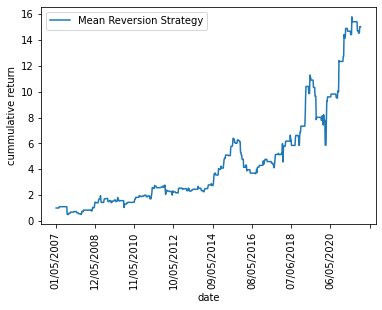

In [504]:
cumret_meanreverse.plot(rot = 90,ylabel = 'cummulative return',legend = 'PNL')

In [505]:
sorted_pnl = pd.DataFrame(pnl,columns = {'ret'}).sort_values(by =['ret'],ignore_index = True)
sorted_pnl.head()


,ret
0,-0.530618
1,-0.337587
2,-0.246766
3,-0.238130
4,-0.187940


In [506]:
cvar = (sorted_pnl[sorted_pnl.index<39].sum()/39)[0]
var =sorted_pnl.iloc[39][0]
return_metrics = return_metrics.append({'strategy':'Mean Reversion ','mean':mean,'std':std,'Sharpe':sharpe,'maxdd':maxdd,'maxddd':maxddd,'VaR':var,'CVaR':cvar},ignore_index=True)

0.2390848720944517 0.4325969634952027 0.5526734865699144 -0.7430715939079662 186.0
ret   -0.135113
dtype: float64
ret   -0.049615
Name: 39, dtype: float64


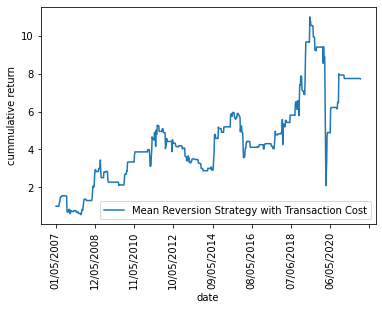

In [507]:
#mean reverse transaction cost
mean,std,sharpe,pnl = mean_rev_transaction_cost(0.8,1,1*-0.2,104)
cumret_meanreverse = pd.DataFrame(pnl+1).cumprod()
maxdd,maxddd,t = calculateMaxDD(cumret_meanreverse) 
cumret_meanreverse['date'] = df.index
cumret_meanreverse.set_index('date',inplace = True)
cumret_meanreverse.columns = ['Mean Reversion Strategy with Transaction Cost']
cumret_meanreverse.plot(rot = 90,ylabel = 'cummulative return',legend = 'PNL')
sorted_pnl = pd.DataFrame(pnl,columns = {'ret'}).sort_values(by =['ret'],ignore_index = True)
print(mean,std,sharpe,maxdd,maxddd)
print(sorted_pnl[sorted_pnl.index<39].sum()/39) #cvar
print(sorted_pnl.iloc[39])
cvar = (sorted_pnl[sorted_pnl.index<39].sum()/39)[0]
var =sorted_pnl.iloc[39][0]
return_metrics = return_metrics.append({'strategy':'Mean Reversion with transaction cost ','mean':mean,'std':std,'Sharpe':sharpe,'maxdd':maxdd,'maxddd':maxddd,'VaR':var,'CVaR':cvar},ignore_index=True)

0.34604022686247965 0.6708748167988976 0.5158044663438442 -0.579881446478528 163.0
ret   -0.172432
dtype: float64
ret   -0.116452
Name: 39, dtype: float64


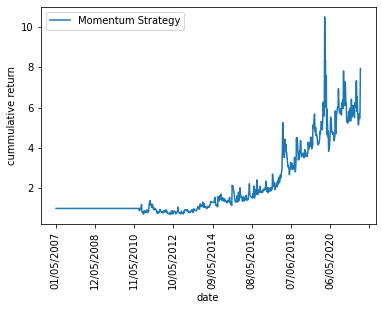

In [508]:
#momentum
mean,std,sharpe,pnl = momentum2(0.8,0.005,0.005*1.2,156)
cumret_meanreverse = pd.DataFrame(pnl+1).cumprod()
maxdd,maxddd,t = calculateMaxDD(cumret_meanreverse) 
cumret_meanreverse['date'] = df.index
cumret_meanreverse.set_index('date',inplace = True)
cumret_meanreverse.columns = ['Momentum Strategy']
cumret_meanreverse.plot(rot = 90,ylabel = 'cummulative return',legend = 'PNL')
sorted_pnl = pd.DataFrame(pnl,columns = {'ret'}).sort_values(by =['ret'],ignore_index = True)
print(mean,std,sharpe,maxdd,maxddd)
print(sorted_pnl[sorted_pnl.index<39].sum()/39) #cvar
print(sorted_pnl.iloc[39])
cvar = (sorted_pnl[sorted_pnl.index<39].sum()/39)[0]
var =sorted_pnl.iloc[39][0]
return_metrics = return_metrics.append({'strategy':'Momentum','mean':mean,'std':std,'Sharpe':sharpe,'maxdd':maxdd,'maxddd':maxddd,'VaR':var,'CVaR':cvar},ignore_index=True)

0.3438651946874475 0.6709263241070104 0.5125230332035714 -0.5782009624306739 163.0
ret   -0.172445
dtype: float64
ret   -0.118443
Name: 39, dtype: float64


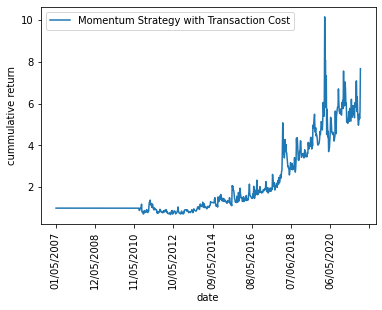

In [509]:
#momentum cost
mean,std,sharpe,pnl = momentum2_transaction_cost(0.8,0.005,0.005*1.2,156)
cumret_meanreverse = pd.DataFrame(pnl+1).cumprod()
maxdd,maxddd,t = calculateMaxDD(cumret_meanreverse) 
cumret_meanreverse['date'] = df.index
cumret_meanreverse.set_index('date',inplace = True)
cumret_meanreverse.columns = ['Momentum Strategy with Transaction Cost']
cumret_meanreverse.plot(rot = 90,ylabel = 'cummulative return',legend = 'PNL')
sorted_pnl = pd.DataFrame(pnl,columns = {'ret'}).sort_values(by =['ret'],ignore_index = True)
print(mean,std,sharpe,maxdd,maxddd)
print(sorted_pnl[sorted_pnl.index<39].sum()/39) #cvar
print(sorted_pnl.iloc[39])
cvar = (sorted_pnl[sorted_pnl.index<39].sum()/39)[0]
var =sorted_pnl.iloc[39][0]
return_metrics = return_metrics.append({'strategy':'Momentum with transaction cost ','mean':mean,'std':std,'Sharpe':sharpe,'maxdd':maxdd,'maxddd':maxddd,'VaR':var,'CVaR':cvar},ignore_index=True)

In [510]:
cdx = df['CDX IG 5Y SPREAD'].pct_change()

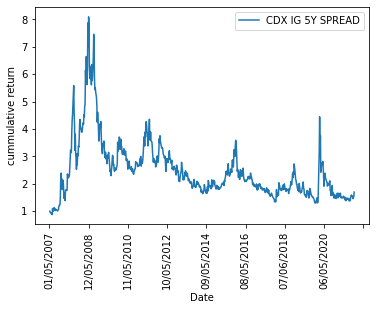

In [511]:
cdx_ret = (cdx+1).cumprod()
cdx_ret.plot(rot = 90,ylabel = 'cummulative return',legend = 'PNL')

In [523]:
mean = np.nanmean(cdx)*52
std = np.nanstd(cdx)*np.sqrt(52)
sharpe = mean/std*np.sqrt(52)
maxdd,maxddd,t = calculateMaxDD(cdx_ret)
sorted_pnl = pd.DataFrame(cdx.values,columns = {'ret'}).sort_values(by =['ret'],ignore_index = True)
cvar = (sorted_pnl[sorted_pnl.index<39].sum()/39)[0]
var =sorted_pnl.iloc[39][0]
return_metrics = return_metrics.append({'strategy':'CDX IG ','mean':mean,'std':std,'Sharpe':sharpe,'maxdd':maxdd,'maxddd':maxddd,'VaR':var,'CVaR':cvar},ignore_index=True)

0.189064957844513 0.5659679330691876 2.4089117424202047 -0.7470261877383437 677.0


1a) We do need the volatiility to adjust the signals. For instance, in mean reversion strategy the signal is generated using the z-score of the spread to a threshold. The z-score is computed with the volatility of the spread, if the volatility is high we would receive smaller z-score and the trade-signal would be less frequent compare to small volatility given we have the same entry and exit thresholds for trading 

1b) For mean-reversion strategy, we enter a trade (either long or short the spread) when the absolute value of z-score is greater than the entrance threshold at time t and we exit the trade (position back to 0) when the absolute value of z-score is less than the exit threshold.

As for momentum trade we compare the current spread with the rolling spread, if the rolling spread is greater than entrance threshold, we would long the spread given the believe that stock that performed well in the past will continue to outperform, and if the rolling spread is less than the negative of entrance threshold we would short the spread. We clear our position if the rolling spread excessed exit threshold percentage of return as we worry that it might mean reverse. 

c) The maximum adverse move of a momentum of the period where the strategy keeps revert back to the mean, and the maximum adverse move of a mean reversion model is when the spread keeps on gaining or keeps on losing. We use the maximum drawdown of the stategy to see the maximum adverse move of the stategies and use the maximum drawdown duration to see how long does it take for the stategy to go back to its high water mark position. 

In [524]:
return_metrics

,std,maxdd,maxddd,CVaR,strategy,mean,VaR,Sharpe
0,0.376201,-0.441564,144.0,-0.118182,Mean Reversion,0.257475,-0.050695,0.684410
1,0.432597,-0.743072,186.0,-0.135113,Mean Reversion with transaction cost,0.239085,-0.0496154,0.552673
2,0.670875,-0.579881,163.0,-0.172432,Momentum,0.346040,-0.116452,0.515804
3,0.670926,-0.578201,163.0,-0.172445,Momentum with transaction cost,0.343865,-0.118443,0.512523
4,0.565968,-0.747026,677.0,-0.146492,CDX IG,0.189065,"ret -0.101114 Name: 39, dtype: float64",2.408912
5,0.565968,-0.747026,677.0,-0.146492,CDX IG,0.189065,-0.101114,2.408912


1d) The analytics I choose for each model is the standard devation, mean, Sharpe ratio, maximum drawdown, maximum drawdown duration, 5% weekly VaR and 5% weekly CVaR, and the results for each strategy is demonstrated in the table above. Mean, standard deviation and Sharpe ratio are the standard evaluation metrics for a strategy, it allows us to see the return along with the risks that is associated with the return. Sharpe ratio gives us excess return per unit risk, and our goal for trading strategies is to maximize the Sharpe ratio. All the other metrics are used for risk control, as it is essential for any financial firms. Maximum Drawdown and Maximum Drawdown duration tells us what is the maximum loss from historical high watermark, and how long does it take to recover to the high watermark. If our risk appetite is small and we do not wish to lose the amount indicated in maximum drawdown, then the stategy is not suitable. 5% Weekly VaR and 5% Weekly CVaR gives us the worst case scenarios that there are 5% chance in a week, we could lose more than VaR amount of return, and if we have incurred a loss that is greater than VaR amount of return, the expected average loss is the CVaR amount. Those two are also good risk indicators for the risk control of the strategy as there would be a threshold we can not exceed. 

1e) please see the attached powerpoint slide 

1f) please see the analytics in the table above, we see that for mean reversion strategy, the transaction costs impacted our strategy return more severe than momentum strategy. We changed our entrance threshold from 0.8 to 1 for the most optimal trading parameters and changed the lookback period from 8 weeks to 104 weeks, all of the adjustments is to reduce trading frequency and thus minimize the impact from transaction costs. By tightening the threshold, we are missing the opportunity to gain from small mean reversion spread to compensate for the high transaction cost. The trading signal would be less frequent, for transactions that lead to less than 0.25% of return will be ignored. On the other hand, momentum strategy does not seem to be impacted much as in the strategy the trading was infrequent to start with and the cost diminishes with higher mean return. 

One way to reduce the transaction cost drag on the strategy is to increase the rebalancing period, instead of weekly rebalancing, we could monthly rebalance our strategy, however this could lead to missing of trading signals. Another way is to set the entrance/exit threshold tighter like in the mean reversion case, this would also reduce the number of transaction needed. 